# A. Gradient Vanishing/Exploding Problems

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def cls():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)


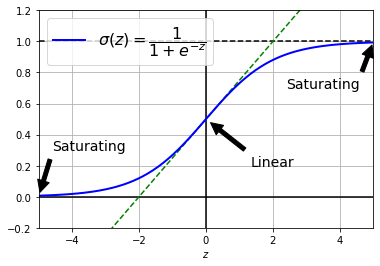

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)
plt.show()

## A-1. Weight Initializer
Xavier & He Initilizer

In [4]:
# You can initialize He by kernel_initializer=he_normal or he_uniform
# By default it is initialize as glorat or xavier
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

# If you want to use variance scaling on weights
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## A-2. Non Saturating Activation Function
Relu, sigmoid are the activation function which derivative saturates to 0 when its value extreme high or extreme low.
We will discuss some non saturated activation functions here.

### A-2-1. Leaky RELU (Rectified Linear Unit)

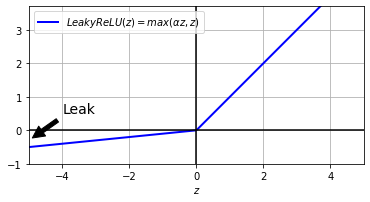

In [5]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [6]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

In [7]:
# We need to define activation seperately when we use while building model

In [8]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### A-2-2. ELU (Exponential Linear Unit)

In [10]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

### A-2-3. SELU (Scaled ELU)

> By default, the SELU hyperparameters (**scale** and **alpha**) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

- It will perform best when we use it with lecun_uniform/lecun_normal weight initializer

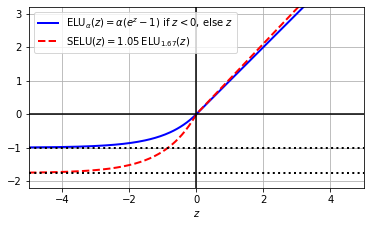

In [11]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [12]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

## A-3. Batch Normalization

In [37]:
cls()
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28,28)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [20]:
# 2368 are non-trainable params
# First BN layer adds 3136 which is 4*784. [For a 28*28 there will be 784 features. each feature have sigma, mu, gamma, and beta param for BN]
# Second BN layer adds 1200
# Third BN layer adds 400
# total would be = 3136+1200+400 = 4736 and divide by 2 --> 2368 [ Because sigma, mu are moving mean and std they will not train in backpropagation]

In [29]:
# Lets check params
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
# Lets load some data
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
x_train, x_valid, x_test = x_train / 255, x_valid / 255, x_test / 255
print(x_train.shape, x_valid.shape, x_test.shape)

(54000, 28, 28) (6000, 28, 28) (10000, 28, 28)


In [39]:
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer="sgd")
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=2)

Epoch 1/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.5516 - accuracy: 0.8082 - val_loss: 0.4345 - val_accuracy: 0.8470
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4218 - accuracy: 0.8521 - val_loss: 0.3975 - val_accuracy: 0.8623


In [40]:
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer="adam")
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=2)

Epoch 1/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4363 - accuracy: 0.8424 - val_loss: 0.3650 - val_accuracy: 0.8678
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3523 - accuracy: 0.8715 - val_loss: 0.3415 - val_accuracy: 0.8773


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a *BatchNormalization layer* does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set *use_bias=False* when creating those layers:

In [41]:
# When we want to use BN layer before the activation layers
cls()
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28,28)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.ELU(),
                                    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation("elu"),
                                    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer="adam")
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=2)

Epoch 1/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4818 - accuracy: 0.8284 - val_loss: 0.3988 - val_accuracy: 0.8540
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3868 - accuracy: 0.8598 - val_loss: 0.3712 - val_accuracy: 0.8668


### A-4. Gradiant Clipping
Used to clip the gradient when it exceed the passed value. It will help in Gradient exploding problem

In [42]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

# Both are same
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

# B. Reusing Pretrained Layers
How to use pretrained custom layers, and fully trained models

#### Let's split the fashion MNIST training set in two:

- X_train_A: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2). [Only total 8 classes].
- X_train_B: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.
The validation set and the test set are also split this way, but without restricting the number of images.

> We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image)

In [94]:
# Lets load some data
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
x_train, x_valid, x_test = x_train / 255, x_valid / 255, x_test / 255
print(x_train.shape, x_valid.shape, x_test.shape)

# These are the 10 classes
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

(54000, 28, 28) (6000, 28, 28) (10000, 28, 28)


In [71]:
# Now we will split the dataset
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

In [72]:
(x_train_A, y_train_A), (x_train_B, y_train_B) = split_dataset(x_train, y_train)
(x_valid_A, y_valid_A), (x_valid_B, y_valid_B) = split_dataset(x_valid, y_valid)
(x_test_A, y_test_A), (x_test_B, y_test_B) = split_dataset(x_test, y_test)
x_train_B = x_train_B[:200]
y_train_B = y_train_B[:200]

print("Set A: ", x_train_A.shape, x_valid_A.shape, x_test_A.shape)
print("Set B: ", x_train_B.shape, y_train_B.shape)

Set A:  (43220, 28, 28) (4780, 28, 28) (8000, 28, 28)
Set B:  (200, 28, 28) (200,)


In [73]:
print("Total classes in Set A: ",np.unique(y_train_A))
print("Total classes in Set B: ",np.unique(y_train_B))

Total classes in Set A:  [0 1 2 3 4 5 6 7]
Total classes in Set B:  [0. 1.]


In [74]:
# Building the model using set A and save it.
cls()
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="elu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="elu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(50,  activation="elu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model_A.fit(x_train_A, y_train_A, epochs=10, validation_data=(x_valid_A, y_valid_A))
model_A.save("model/my_model_A")

Epoch 1/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.3180 - accuracy: 0.8851 - val_loss: 0.2504 - val_accuracy: 0.9130
Epoch 2/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.2325 - accuracy: 0.9157 - val_loss: 0.2316 - val_accuracy: 0.9180
Epoch 3/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.2002 - accuracy: 0.9266 - val_loss: 0.3342 - val_accuracy: 0.8931
Epoch 4/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.1812 - accuracy: 0.9332 - val_loss: 0.2109 - val_accuracy: 0.9272
Epoch 5/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.1679 - accuracy: 0.9387 - val_loss: 0.2109 - val_accuracy: 0.9264
Epoch 6/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.1546 - accuracy: 0.9427 - val_loss: 0.1902 - val_accuracy: 0.9337
Epoch 7/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.1470 - accuracy: 0.9466 - val_loss: 0.1954 - val_accuracy:

In [76]:
# Train model B on set-B without using model A
cls()
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="elu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="elu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(50,  activation="elu",kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model_B.fit(x_train_B, y_train_B, epochs=10, validation_data=(x_valid_B, y_valid_B))
model_B.evaluate(x_test_B, y_test_B)

Epoch 1/10
7/7 [==============================] - 1s 38ms/step - loss: 0.6918 - accuracy: 0.7350 - val_loss: 0.1278 - val_accuracy: 0.9566
Epoch 2/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2510 - accuracy: 0.9050 - val_loss: 0.1819 - val_accuracy: 0.9484
Epoch 3/10
7/7 [==============================] - 0s 19ms/step - loss: 0.2071 - accuracy: 0.9550 - val_loss: 0.1821 - val_accuracy: 0.9500
Epoch 4/10
7/7 [==============================] - 0s 17ms/step - loss: 0.1719 - accuracy: 0.9400 - val_loss: 0.1425 - val_accuracy: 0.9475
Epoch 5/10
7/7 [==============================] - 0s 17ms/step - loss: 0.1274 - accuracy: 0.9500 - val_loss: 0.1940 - val_accuracy: 0.9459
Epoch 6/10
7/7 [==============================] - 0s 16ms/step - loss: 0.1180 - accuracy: 0.9700 - val_loss: 0.1513 - val_accuracy: 0.9566
Epoch 7/10
7/7 [==============================] - 0s 15ms/step - loss: 0.0815 - accuracy: 0.9750 - val_loss: 0.1125 - val_accuracy: 0.9582
Epoch 8/10
7/7 [===========

[0.15540720522403717, 0.949999988079071]

In [79]:
# Model-B gave 95% accuracy on test-B set

# Now lets load model-A to use it with model-B
# Remember model-A trained on 8 classes
# model-B trained on 2 classes
cls()
model_A = tf.keras.models.load_model("model/my_model_A")      # Trained model loaded
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1]) # Excluded last layers as it contained 10 neurons
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid", name='output_layer')) # adding new layer with 1 neuron

#Note that **model_B_on_A** and **model_A** actually share layers now, so when we train one, it will update both models. 
# If we want to avoid that, we need to build **model_B_on_A** on top of a clone of **model_A**: 

In [80]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [82]:
# Same like we did in previous cell
cls()
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid", name='output_layer'))
model_B_on_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 51        
Total params: 270,701
Trainable params: 270,701
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Only last layer we train
for layers in model_B_on_A.layers[:-1]:
    layers.trainable = False
model_B_on_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 51        
Total params: 270,701
Trainable params: 51
Non-trainable params: 270,650
_________________________________________________________________


In [84]:
model_B_on_A.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model_B.fit(x_train_B, y_train_B, epochs=2, validation_data=(x_valid_B, y_valid_B))
# To train lower layers
for layers in model_B_on_A.layers[:-1]:
    layers.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model_B_on_A.fit(x_train_B, y_train_B, epochs=8, validation_data=(x_valid_B, y_valid_B))
model_B_on_A.evaluate(x_test_B, y_test_B)

Epoch 1/2
7/7 [==============================] - 0s 28ms/step - loss: 0.0440 - accuracy: 0.9850 - val_loss: 0.1310 - val_accuracy: 0.9574
Epoch 2/2
7/7 [==============================] - 0s 18ms/step - loss: 0.0365 - accuracy: 0.9850 - val_loss: 0.1302 - val_accuracy: 0.9582
Epoch 1/8
7/7 [==============================] - 1s 34ms/step - loss: 0.4411 - accuracy: 0.8000 - val_loss: 0.1226 - val_accuracy: 0.9574
Epoch 2/8
7/7 [==============================] - 0s 17ms/step - loss: 0.0931 - accuracy: 0.9550 - val_loss: 0.1304 - val_accuracy: 0.9623
Epoch 3/8
7/7 [==============================] - 0s 19ms/step - loss: 0.0678 - accuracy: 0.9700 - val_loss: 0.1378 - val_accuracy: 0.9615
Epoch 4/8
7/7 [==============================] - 0s 17ms/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 0.1228 - val_accuracy: 0.9639
Epoch 5/8
7/7 [==============================] - 0s 17ms/step - loss: 0.0396 - accuracy: 0.9850 - val_loss: 0.1267 - val_accuracy: 0.9639
Epoch 6/8
7/7 [===================

[0.2104317992925644, 0.9539999961853027]

In [85]:
# Net improvement
(1 - (100 - 95.39) / (100 - 94.99)) * 100

7.9840319361278445

In [86]:
# The model accuracy increase by 0.4 percent.

# C. Optimizers

In [95]:
def build_model(optimizer):
    cls()
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="elu",kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="elu",kernel_initializer="he_normal"),
        tf.keras.layers.Dense(50,  activation="elu",kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid)), model
    

In [124]:
# To track on results
res = {'Optimizer':[], 'Score':[], "Accuracy":[]}
result = lambda opt,sc,ac: (res['Optimizer'].append(opt), res['Score'].append(sc),res['Accuracy'].append(ac))

In [97]:
################################
# 1. Stocastic Gradient Decent #
################################
history_sgd, model = build_model(tf.keras.optimizers.SGD(learning_rate=0.001))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 1.0607 - accuracy: 0.6518 - val_loss: 0.7671 - val_accuracy: 0.7512
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6743 - accuracy: 0.7776 - val_loss: 0.6331 - val_accuracy: 0.7923
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5836 - accuracy: 0.8046 - val_loss: 0.5750 - val_accuracy: 0.8080
Epoch 4/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5383 - accuracy: 0.8149 - val_loss: 0.5386 - val_accuracy: 0.8158
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.5270 - accuracy: 0.8151


[0.5269959568977356, 0.8151000142097473]

In [125]:
result('SGD',0.52,81.51)

(None, None, None)

In [98]:
###############
# 2. Momentum #
###############
history_sgd, model = build_model(tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6085 - accuracy: 0.7877 - val_loss: 0.4899 - val_accuracy: 0.8290
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4475 - accuracy: 0.8403 - val_loss: 0.4420 - val_accuracy: 0.8447
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4116 - accuracy: 0.8527 - val_loss: 0.4412 - val_accuracy: 0.8413
Epoch 4/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3884 - accuracy: 0.8604 - val_loss: 0.4056 - val_accuracy: 0.8557
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4129 - accuracy: 0.8499


[0.4128953218460083, 0.8499000072479248]

In [126]:
result('Momentum',0.41,84.99)

(None, None, None)

In [99]:
###################################
# 3. Nestrov Accelerated Gradient #
###################################
history_sgd, model = build_model(tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6023 - accuracy: 0.7914 - val_loss: 0.4869 - val_accuracy: 0.8293
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4435 - accuracy: 0.8421 - val_loss: 0.4435 - val_accuracy: 0.8432
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4088 - accuracy: 0.8535 - val_loss: 0.4311 - val_accuracy: 0.8462
Epoch 4/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3865 - accuracy: 0.8611 - val_loss: 0.4031 - val_accuracy: 0.8585
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4040 - accuracy: 0.8546


[0.4039700925350189, 0.8546000123023987]

In [127]:
result('Nestrov',0.40,85.46)

(None, None, None)

In [120]:
##############
# 4. AdaGrad #
##############
history_sgd, model = build_model(tf.keras.optimizers.Adagrad(learning_rate=1e-3))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.8143 - accuracy: 0.7339 - val_loss: 0.6150 - val_accuracy: 0.7987
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5546 - accuracy: 0.8132 - val_loss: 0.5378 - val_accuracy: 0.8180
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5031 - accuracy: 0.8276 - val_loss: 0.5074 - val_accuracy: 0.8265
Epoch 4/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4774 - accuracy: 0.8340 - val_loss: 0.4848 - val_accuracy: 0.8328
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.8282


[0.48414745926856995, 0.8281999826431274]

In [128]:
result('AdaGrad',0.48,82.81)

(None, None, None)

In [122]:
##############
# 5. RMSProp #
##############
history_sgd, model = build_model(tf.keras.optimizers.RMSprop())
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5180 - accuracy: 0.8111 - val_loss: 0.4737 - val_accuracy: 0.8177
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3882 - accuracy: 0.8563 - val_loss: 0.3972 - val_accuracy: 0.8633
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3538 - accuracy: 0.8718 - val_loss: 0.4478 - val_accuracy: 0.8362
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3313 - accuracy: 0.8801 - val_loss: 0.3872 - val_accuracy: 0.8590
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.3741 - accuracy: 0.8715


[0.37405630946159363, 0.8715000152587891]

In [129]:
result('RMSProp',0.37,87.15)

(None, None, None)

In [130]:
###########
# 6. Adam #
###########
history_sgd, model = build_model(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4812 - accuracy: 0.8238 - val_loss: 0.4565 - val_accuracy: 0.8255
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3751 - accuracy: 0.8608 - val_loss: 0.3994 - val_accuracy: 0.8512
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3363 - accuracy: 0.8754 - val_loss: 0.3750 - val_accuracy: 0.8635
Epoch 4/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3131 - accuracy: 0.8826 - val_loss: 0.3649 - val_accuracy: 0.8668
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.3794 - accuracy: 0.8717


[0.3794373869895935, 0.8716999888420105]

In [131]:
result('Adam',0.37,87.17)

(None, None, None)

In [132]:
#############
# 7. Adamax #
#############
history_sgd, model = build_model(tf.keras.optimizers.Adamax())
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4982 - accuracy: 0.8229 - val_loss: 0.4178 - val_accuracy: 0.8505
Epoch 2/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3819 - accuracy: 0.8606 - val_loss: 0.3927 - val_accuracy: 0.8570
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3433 - accuracy: 0.8735 - val_loss: 0.3665 - val_accuracy: 0.8660
Epoch 4/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3181 - accuracy: 0.8823 - val_loss: 0.3526 - val_accuracy: 0.8722
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.3451 - accuracy: 0.8754


[0.3451217710971832, 0.8754000067710876]

In [133]:
result('Adamax',0.37,87.54)

(None, None, None)

In [134]:
###############
# 8. AdaDelta #
###############
history_sgd, model = build_model(tf.keras.optimizers.Adadelta())
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 1.8798 - accuracy: 0.3628 - val_loss: 1.5537 - val_accuracy: 0.5090
Epoch 2/5
1688/1688 [==============================] - 4s 3ms/step - loss: 1.3547 - accuracy: 0.5831 - val_loss: 1.2229 - val_accuracy: 0.6092
Epoch 3/5
1688/1688 [==============================] - 4s 3ms/step - loss: 1.1167 - accuracy: 0.6442 - val_loss: 1.0513 - val_accuracy: 0.6593
Epoch 4/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.9837 - accuracy: 0.6832 - val_loss: 0.9472 - val_accuracy: 0.6955
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.8791 - accuracy: 0.7127


[0.8791443109512329, 0.7127000093460083]

In [135]:
result('AdaDelta',0.87,71.27)

(None, None, None)

In [136]:
############
# 9. Nadam #
############
history_sgd, model = build_model(tf.keras.optimizers.Nadam())
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4746 - accuracy: 0.8261 - val_loss: 0.4515 - val_accuracy: 0.8335
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3586 - accuracy: 0.8675 - val_loss: 0.3773 - val_accuracy: 0.8620
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3213 - accuracy: 0.8815 - val_loss: 0.4002 - val_accuracy: 0.8550
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2992 - accuracy: 0.8871 - val_loss: 0.3611 - val_accuracy: 0.8685
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.3570 - accuracy: 0.8758


[0.3569546341896057, 0.8758000135421753]

In [137]:
result('Nadam',0.35,87.58)

(None, None, None)

In [138]:
%pip install tensorflow-addons

In [139]:
#############
# 10. AdamW #
#############
import tensorflow_addons as tfa
history_sgd, model = build_model(tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,beta_1=0.9, beta_2=0.999))
model.evaluate(x_test, y_test)

c:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4811 - accuracy: 0.8239 - val_loss: 0.4569 - val_accuracy: 0.8260
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3752 - accuracy: 0.8610 - val_loss: 0.4170 - val_accuracy: 0.8457
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3365 - accuracy: 0.8746 - val_loss: 0.3799 - val_accuracy: 0.8600
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3140 - accuracy: 0.8821 - val_loss: 0.3539 - val_accuracy: 0.8698
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.3799 - accuracy: 0.8719


[0.37994199991226196, 0.8719000220298767]

In [140]:
result('AdamW',0.38,87.19)

(None, None, None)

In [144]:
import pandas as pd
pd.DataFrame(res).sort_values('Accuracy', ascending=False).reset_index(drop=True)

,Optimizer,Score,Accuracy
0,Nadam,0.35,87.58
1,Adamax,0.37,87.54
2,AdamW,0.38,87.19
3,Adam,0.37,87.17
4,RMSProp,0.37,87.15
5,Nestrov,0.40,85.46
6,Momentum,0.41,84.99
7,AdaGrad,0.48,82.81
8,SGD,0.52,81.51
9,AdaDelta,0.87,71.27


In [145]:
# We can see-
# There is 5% improvement in Accuracy just by changing optimizer from SGD varients' to Adam varients'.

# D. Learning Rate Scheduling

### D-1. Power Scheduling
**lr = lr0 / (1 + steps / s)\*\*c**
- Keras uses c=1 and s = 1 / decay

In [182]:
# To track on results
res = {'Optimizer':[], 'Score':[], "Accuracy":[], 'Decay':[]}
result = lambda opt,sc,ac: (res['Optimizer'].append("SGD"), res['Score'].append(sc),res['Accuracy'].append(ac),res['Decay'].append(opt))

In [183]:
h_lr_power, model = build_model(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6071 - accuracy: 0.7891 - val_loss: 0.5128 - val_accuracy: 0.8117
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4525 - accuracy: 0.8391 - val_loss: 0.4505 - val_accuracy: 0.8420
Epoch 3/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4177 - accuracy: 0.8516 - val_loss: 0.4398 - val_accuracy: 0.8440
Epoch 4/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3973 - accuracy: 0.8575 - val_loss: 0.4257 - val_accuracy: 0.8512
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4113 - accuracy: 0.8491


[0.41133520007133484, 0.8490999937057495]

In [184]:
result('Power S',0.41,84.90)

(None, None, None, None)

### D-2. Exponential Scheduling

> lr = lr0 * 0.1 ** (epoch / s)

In [187]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [188]:
def build_m():
    cls()
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="elu",kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="elu",kernel_initializer="he_normal"),
        tf.keras.layers.Dense(50,  activation="elu",kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")])

In [189]:
model = build_m()
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
cb_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
h_lr_exp = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid),callbacks=[cb_lr_scheduler])
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.6058 - accuracy: 0.7890 - val_loss: 0.5114 - val_accuracy: 0.8128
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4495 - accuracy: 0.8400 - val_loss: 0.4489 - val_accuracy: 0.8418
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4138 - accuracy: 0.8525 - val_loss: 0.4376 - val_accuracy: 0.8448
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3926 - accuracy: 0.8594 - val_loss: 0.4229 - val_accuracy: 0.8527
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4069 - accuracy: 0.8517


[0.40694180130958557, 0.8517000079154968]

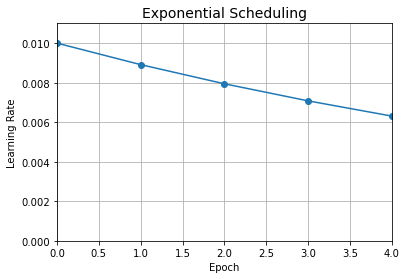

In [197]:
plt.plot(h_lr_exp.epoch, h_lr_exp.history["lr"], "o-")
plt.axis([0, 5 - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [194]:
result('Expon S',0.40,85.17)
res

{'Optimizer': ['SGD', 'SGD'],
 'Score': [0.41, 0.4],
 'Accuracy': [84.9, 85.17],
 'Decay': ['Power S', 'Expon S']}

In [225]:
K = tf.keras.backend

def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 5)

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)    

In [227]:
import math

model = build_m()
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),metrics=["accuracy"])
n_steps   = 5 * math.ceil(len(x_train) / 32)
exp_decay = ExponentialDecay(n_steps)
history  = model.fit(x_train, y_train, epochs=5,validation_data=(x_valid, y_valid), callbacks=[exp_decay])
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6100 - accuracy: 0.7889 - val_loss: 0.5134 - val_accuracy: 0.8132
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4577 - accuracy: 0.8382 - val_loss: 0.4578 - val_accuracy: 0.8403
Epoch 3/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4280 - accuracy: 0.8488 - val_loss: 0.4477 - val_accuracy: 0.8447
Epoch 4/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4135 - accuracy: 0.8529 - val_loss: 0.4334 - val_accuracy: 0.8477
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4402 - accuracy: 0.8404


[0.4401775002479553, 0.840399980545044]

In [198]:
result('Expon S step',0.44,84.04)
res

(None, None, None, None)

In [224]:
# Using Keras scheduler
n_steps = 5 * math.ceil(len(x_train) / 32)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
h_power_lr, model = build_model(tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate))
model.evaluate(x_test, y_test)

ValueError: The Nadam optimizer does not support tf.keras.optimizers.LearningRateSchedules as the learning rate.

In [200]:
result('Expon S keras',0.44,84.04)
res

{'Optimizer': ['SGD', 'SGD', 'SGD', 'SGD'],
 'Score': [0.41, 0.4, 0.44, 0.44],
 'Accuracy': [84.9, 85.17, 84.04, 84.04],
 'Decay': ['Power S', 'Expon S', 'Expon S step', 'Expon S keras']}

### D-3. Piecewise Constant Scheduling

In [201]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001


def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])        

In [202]:
model = build_m()
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
cb_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
h_exp_lr = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid),callbacks=[cb_lr_scheduler])
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6058 - accuracy: 0.7890 - val_loss: 0.5114 - val_accuracy: 0.8128
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4505 - accuracy: 0.8394 - val_loss: 0.4483 - val_accuracy: 0.8422
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4135 - accuracy: 0.8519 - val_loss: 0.4365 - val_accuracy: 0.8460
Epoch 4/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3906 - accuracy: 0.8605 - val_loss: 0.4222 - val_accuracy: 0.8528
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4012 - accuracy: 0.8549


[0.40123504400253296, 0.8549000024795532]

In [203]:
# using keras scheduler
n_steps_ = math.ceil(len(x_train) / 32)
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[5. * n_steps_, 15. * n_steps_], values=[0.01, 0.005, 0.001])
h_power_lr, model = build_model(tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.6058 - accuracy: 0.7890 - val_loss: 0.5114 - val_accuracy: 0.8128
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4505 - accuracy: 0.8394 - val_loss: 0.4483 - val_accuracy: 0.8422
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4135 - accuracy: 0.8519 - val_loss: 0.4365 - val_accuracy: 0.8460
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3906 - accuracy: 0.8605 - val_loss: 0.4222 - val_accuracy: 0.8528
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4012 - accuracy: 0.8549


[0.40123504400253296, 0.8549000024795532]

In [204]:
result('Piecewise D',0.40,85.50)
result('Piecewise D Keras',0.40,85.50)
res

{'Optimizer': ['SGD', 'SGD', 'SGD', 'SGD', 'SGD', 'SGD'],
 'Score': [0.41, 0.4, 0.44, 0.44, 0.4, 0.4],
 'Accuracy': [84.9, 85.17, 84.04, 84.04, 85.5, 85.5],
 'Decay': ['Power S',
  'Expon S',
  'Expon S step',
  'Expon S keras',
  'Piecewise D',
  'Piecewise D Keras']}

### D-4. Performance Scheduling

In [205]:
model = build_m()
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
cb_lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
h_per_lr = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid),callbacks=[cb_lr_scheduler])
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 1.0607 - accuracy: 0.6518 - val_loss: 0.7671 - val_accuracy: 0.7512
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6743 - accuracy: 0.7776 - val_loss: 0.6331 - val_accuracy: 0.7923
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5836 - accuracy: 0.8046 - val_loss: 0.5750 - val_accuracy: 0.8080
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5383 - accuracy: 0.8149 - val_loss: 0.5386 - val_accuracy: 0.8158
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5270 - accuracy: 0.8151


[0.5269959568977356, 0.8151000142097473]

In [206]:
result('Performance S',0.52,81.51)

(None, None, None, None)

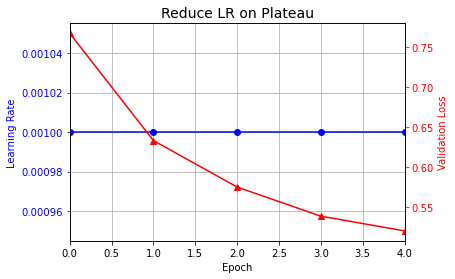

In [207]:
plt.plot(h_per_lr.epoch, h_per_lr.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, 5 - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(h_per_lr.epoch, h_per_lr.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### D-5. 1Cycle scheduling

The **ExponentialLearningRate** custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant **factor.** It also saves the learning rate and loss at each batch. Since **logs["loss"]** is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [208]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The **find_learning_rate()** function trains the model using the **ExponentialLearningRate** callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [209]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The **plot_lr_vs_loss()** function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [210]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

422/422 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.4196


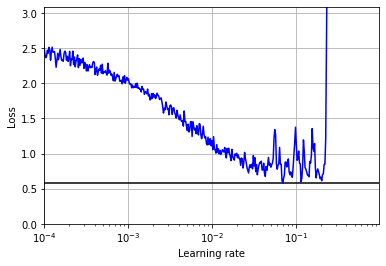

In [211]:
#Let's build a simple Fashion MNIST model and compile it:
model = build_m()
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, x_train, y_train, epochs=1,batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10–1.

The **OneCycleScheduler** custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [212]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [220]:
model = build_m()
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])
onecycle = OneCycleScheduler(math.ceil(len(x_train) / batch_size) * 5,max_lr=0.1)
history = model.fit(x_train, y_train, epochs=5, batch_size=batch_size,validation_data=(x_valid, y_valid),callbacks=[onecycle])

Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.7551 - accuracy: 0.7411 - val_loss: 0.5192 - val_accuracy: 0.8177
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4955 - accuracy: 0.8213 - val_loss: 0.5181 - val_accuracy: 0.8120
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4273 - accuracy: 0.8444 - val_loss: 0.4413 - val_accuracy: 0.8337
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.3712 - accuracy: 0.8641 - val_loss: 0.3820 - val_accuracy: 0.8640
Epoch 5/5
422/422 [==============================] - 2s 5ms/step - loss: 0.3444 - accuracy: 0.8751 - val_loss: 0.3717 - val_accuracy: 0.8688


In [222]:
result('OneCycle',0.49,82.17)

(None, None, None, None)

In [223]:
##########################################
# Improvement using learning rate decays #
##########################################
# Raw SGD accuracy was 81%
# Now you can see by changing learning rate it improved by 4%
pd.DataFrame(res).sort_values('Accuracy', ascending=False).reset_index(drop=True)

,Optimizer,Score,Accuracy,Decay
0,SGD,0.40,85.50,Piecewise D
1,SGD,0.40,85.50,Piecewise D Keras
2,SGD,0.40,85.17,Expon S
3,SGD,0.41,84.90,Power S
4,SGD,0.44,84.04,Expon S step
5,SGD,0.44,84.04,Expon S keras
6,SGD,0.49,82.17,OneCycle
7,SGD,0.52,81.51,Performance S


# E. Avoiding Overfitting Through Regularization
### E-1. ℓ1 and ℓ2 regularization

In [216]:
layer = tf.keras.layers.Dense(10, activation="relu",kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01))

Or use **l1(0.1)** for ℓ1 regularization with a factor of 0.1, or **l1_l2(0.1, 0.01)** for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively.

In [217]:
# If you dont want to write each line again and again then partial from functools will help you
from functools import partial
RegularizedDense = partial(tf.keras.layers.Dense,activation="relu",kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l2(0.01))
cls()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [218]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
1688/1688 [==============================] - 3s 1ms/step - loss: 3.1458 - accuracy: 0.7750 - val_loss: 1.9387 - val_accuracy: 0.7908
Epoch 2/5
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4454 - accuracy: 0.8147 - val_loss: 1.1668 - val_accuracy: 0.8127
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 1.0303 - accuracy: 0.8171 - val_loss: 0.9849 - val_accuracy: 0.7965
Epoch 4/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.9198 - accuracy: 0.8161 - val_loss: 0.9341 - val_accuracy: 0.7950
Epoch 5/5
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8857 - accuracy: 0.8179 - val_loss: 0.8870 - val_accuracy: 0.8115


### E-2. Dropout

In [229]:
cls()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6758 - accuracy: 0.7521 - val_loss: 0.4526 - val_accuracy: 0.8315
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5109 - accuracy: 0.8129 - val_loss: 0.4221 - val_accuracy: 0.8430
Epoch 3/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4721 - accuracy: 0.8264 - val_loss: 0.4188 - val_accuracy: 0.8410
Epoch 4/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4494 - accuracy: 0.8340 - val_loss: 0.3848 - val_accuracy: 0.8585
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4023 - accuracy: 0.8534


[0.40225380659103394, 0.8533999919891357]

> Note: make sure to use **AlphaDropout** instead of Dropout if you want to build a self-normalizing neural net using **SELU**.

### E-3. Monte Carlo(MC) Dropout

In [231]:
cls()

In [232]:
y_probas = np.stack([model(x_test, training=True)for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_proba

array([[2.7310240e-04, 2.4369091e-04, 1.1663308e-04, ..., 1.2146471e-01,
        6.4492086e-04, 8.5218084e-01],
       [1.7159666e-03, 3.7326376e-05, 9.4363898e-01, ..., 7.7966536e-07,
        6.7002613e-05, 1.1051327e-06],
       [5.0890376e-05, 9.9811846e-01, 3.6609094e-05, ..., 1.0060728e-06,
        2.2292641e-06, 5.0586806e-07],
       ...,
       [4.7553228e-03, 2.4672574e-05, 3.8906292e-04, ..., 2.4750619e-04,
        9.9006730e-01, 9.9389372e-06],
       [6.9629961e-05, 9.8895609e-01, 1.3909070e-05, ..., 9.8531154e-06,
        4.2570823e-06, 1.8107428e-05],
       [1.0331578e-03, 3.0658569e-04, 9.3987747e-04, ..., 1.8467206e-01,
        1.7861292e-02, 5.7091005e-03]], dtype=float32)

In [238]:
model.predict(x_test[:1]).round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.006, 0.   , 0.062, 0.   ,
        0.931]], dtype=float32)

In [239]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.   , 0.121, 0.001,
       0.852], dtype=float32)

In [240]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.001, 0.001, 0.001, 0.001, 0.   , 0.053, 0.001, 0.128, 0.002,
       0.141], dtype=float32)

In [241]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8524

In [243]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Convert Dropout to MCDropout
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([MCDropout(layer.rate) if isinstance(layer, Dropout) else layer for layer in model.layers])
mc_model.set_weights(model.get_weights()) # Here I didn't retrain the model for MCDropout just coping the weights        

In [258]:
mc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [259]:
# Model works without retrain
cls()
np.mean([mc_model.predict(x_test[:1]) for sample in range(100)], axis=0).round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.12, 0.  , 0.84]],
      dtype=float32)

### E-4. Max Norm

In [260]:
dense = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_constraint=tf.keras.constraints.max_norm(1.))

In [261]:
MaxNormDense = partial(tf.keras.layers.Dense,activation="elu", kernel_initializer="he_normal",kernel_constraint=tf.keras.constraints.max_norm(1.))
cls()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 1.3213 - accuracy: 0.6236 - val_loss: 0.9525 - val_accuracy: 0.7030
Epoch 2/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.8392 - accuracy: 0.7277 - val_loss: 0.7687 - val_accuracy: 0.7578
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.7160 - accuracy: 0.7616 - val_loss: 0.6875 - val_accuracy: 0.7768
Epoch 4/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6511 - accuracy: 0.7814 - val_loss: 0.6382 - val_accuracy: 0.7878
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.7865


[0.6167654991149902, 0.7864999771118164]